# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "RF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'RF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups            
Sample_037  Q9P232                       15.890
Sample_013  O00391                       17.523
Sample_177  P10253                       15.253
Sample_169  A0A087WUT8;O95196;O95196-2   17.574
Sample_189  Q9UHL4                       17.870
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by RF: runs/alzheimer_study/preds/pred_real_na_RF.csv


Sample ID   protein groups 
Sample_190  A2RU67            13.392
Sample_026  P09172            13.783
Sample_036  Q8N3G9;Q8N3G9-2   12.029
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 13.362
            A0A075B6Q5                 13.193
            A0A075B6R2                 14.166
            A0A075B6S5                 11.854
            A0A087WSY4                 12.536
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.660
            Q9UI40;Q9UI40-2            14.018
            Q9UIW2                     12.458
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   11.806
            Q9UP79                     12.680
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.231,15.050,16.842,19.863,15.548,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.029,19.067,...,15.528,15.576,14.157,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.661,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.555,17.705,17.039,16.105,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.964,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.667,15.345,17.084,18.708,14.249,19.433,12.511,11.275
Sample_207,15.739,16.877,15.469,16.898,14.656,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,13.362,...,16.012,15.178,13.081,15.050,16.842,19.863,12.268,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.222,19.067,16.188,...,15.528,15.576,11.876,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,12.630,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,14.453,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.007,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,12.024,15.345,17.084,18.708,14.249,19.433,12.173,12.820
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 373.66it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.66it/s]

100%|██████████| 2/2 [00:00<00:00,  6.64it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.20it/s]

100%|██████████| 3/3 [00:00<00:00,  4.49it/s]

100%|██████████| 3/3 [00:00<00:00,  4.73it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.47it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.75it/s]

100%|██████████| 4/4 [00:01<00:00,  3.56it/s]

100%|██████████| 4/4 [00:01<00:00,  3.78it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.34it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.68it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.40it/s]

100%|██████████| 5/5 [00:01<00:00,  3.15it/s]

100%|██████████| 5/5 [00:01<00:00,  3.43it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.07it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.33it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.88it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.85it/s]

100%|██████████| 6/6 [00:01<00:00,  2.92it/s]

100%|██████████| 6/6 [00:01<00:00,  3.08it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  3.85it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.24it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.87it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.79it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.70it/s]

100%|██████████| 7/7 [00:02<00:00,  2.77it/s]

100%|██████████| 7/7 [00:02<00:00,  2.88it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.47it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.30it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.97it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.97it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  2.91it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.75it/s]

100%|██████████| 8/8 [00:02<00:00,  2.69it/s]

100%|██████████| 8/8 [00:02<00:00,  2.94it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.27it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.23it/s]

 44%|████▍     | 4/9 [00:01<00:01,  2.82it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.75it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.58it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.57it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.56it/s]

100%|██████████| 9/9 [00:03<00:00,  2.53it/s]

100%|██████████| 9/9 [00:03<00:00,  2.71it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.62it/s]

 30%|███       | 3/10 [00:00<00:02,  3.44it/s]

 40%|████      | 4/10 [00:01<00:02,  2.89it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.66it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.57it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.54it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.59it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.60it/s]

100%|██████████| 10/10 [00:03<00:00,  2.63it/s]

100%|██████████| 10/10 [00:03<00:00,  2.75it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  6.05it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.75it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.21it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.84it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  2.69it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.61it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.44it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.59it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.64it/s]

100%|██████████| 11/11 [00:03<00:00,  2.72it/s]

100%|██████████| 11/11 [00:03<00:00,  2.83it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  4.09it/s]

 25%|██▌       | 3/12 [00:01<00:03,  2.48it/s]

 33%|███▎      | 4/12 [00:01<00:03,  2.42it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.52it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.31it/s]

 58%|█████▊    | 7/12 [00:02<00:02,  2.32it/s]

 67%|██████▋   | 8/12 [00:03<00:01,  2.24it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.15it/s]

 83%|████████▎ | 10/12 [00:04<00:00,  2.31it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.35it/s]

100%|██████████| 12/12 [00:04<00:00,  2.43it/s]

100%|██████████| 12/12 [00:04<00:00,  2.41it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  3.90it/s]

 23%|██▎       | 3/13 [00:01<00:04,  2.49it/s]

 31%|███       | 4/13 [00:01<00:03,  2.41it/s]

 38%|███▊      | 5/13 [00:01<00:03,  2.59it/s]

 46%|████▌     | 6/13 [00:02<00:02,  2.62it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.47it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.45it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.45it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.46it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.46it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.50it/s]

100%|██████████| 13/13 [00:05<00:00,  2.61it/s]

100%|██████████| 13/13 [00:05<00:00,  2.56it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.11it/s]

 21%|██▏       | 3/14 [00:01<00:03,  2.76it/s]

 29%|██▊       | 4/14 [00:01<00:04,  2.48it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.55it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.39it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.56it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.61it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.47it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.42it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.39it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.40it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.36it/s]

100%|██████████| 14/14 [00:05<00:00,  2.39it/s]

100%|██████████| 14/14 [00:05<00:00,  2.48it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:03,  3.85it/s]

 20%|██        | 3/15 [00:01<00:04,  2.42it/s]

 27%|██▋       | 4/15 [00:01<00:04,  2.43it/s]

 33%|███▎      | 5/15 [00:01<00:04,  2.47it/s]

 40%|████      | 6/15 [00:02<00:03,  2.53it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.50it/s]

 53%|█████▎    | 8/15 [00:03<00:02,  2.42it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.38it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  2.42it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.42it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.46it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.51it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.41it/s]

100%|██████████| 15/15 [00:06<00:00,  2.49it/s]

100%|██████████| 15/15 [00:06<00:00,  2.49it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.003      0.069 0.025          0.796 0.321       0.120   
2             0.004 0.002      0.057 0.018          0.771 0.090       0.703   
3             0.004 0.002      0.054 0.015          0.764 0.091       0.694   
4             0.004 0.003      0.054 0.015          0.779 0.096       0.693   
5             0.004 0.000      0.052 0.015          0.756 0.106       0.703   
6             0.004 0.001      0.050 0.011          0.792 0.093       0.797   
7             0.004 0.002      0.050 0.011          0.785 0.096       0.791   
8             0.004 0.002      0.049 0.008          0.855 0.077       0.853   
9             0.004 0.003      0.051 0.014          0.854 0.077       0.859   
10            0.005 0.003      0.054 0.016          0.852 0.074       0.857   
11            0.004 0.002      0.047 0.010          0.851 0.076       0.851   
12            0.005 0.003      0.051 0.012          0.850 0.077       0.848   
13            0.004 0.002      0.050 0.011          0.843 0.071       0.841   
14            0.004 0.002      0.052 0.013          0.836 0.077       0.828   
15            0.004 0.000      0.049 0.010          0.831 0.077       0.824   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.084   0.201 0.126                  0.553 0.041        0.854   
2          0.102   0.730 0.073                  0.773 0.057        0.854   
3          0.108   0.721 0.076                  0.767 0.059        0.849   
4          0.102   0.727 0.070                  0.771 0.054        0.849   
5          0.099   0.723 0.080                  0.766 0.065        0.857   
6          0.098   0.790 0.071                  0.820 0.059        0.908   
7          0.109   0.782 0.079                  0.814 0.065        0.905   
8          0.096   0.850 0.067                  0.872 0.058        0.926   
9          0.090   0.854 0.068                  0.875 0.059        0.927   
10         0.090   0.851 0.066                  0.873 0.056        0.926   
11         0.088   0.848 0.065                  0.870 0.056        0.924   
12         0.090   0.846 0.067                  0.868 0.057        0.923   
13         0.094   0.839 0.066                  0.863 0.055        0.922   
14         0.093   0.829 0.068                  0.854 0.057        0.920   
15         0.095   0.824 0.068                  0.850 0.058        0.919   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.065                  0.826 0.089        210.000 0.000  
2          0.057                  0.811 0.083        210.000 0.000  
3          0.057                  0.805 0.082        210.000 0.000  
4          0.057                  0.811 0.083        210.000 0.000  
5          0.054                  0.823 0.073        210.000 0.000  
6          0.044                  0.891 0.051        210.000 0.000  
7          0.045                  0.889 0.051        210.000 0.000  
8          0.041                  0.911 0.049        210.000 0.000  
9          0.042                  0.914 0.049        210.000 0.000  
10         0.042                  0.913 0.049        210.000 0.000  
11         0.044                  0.910 0.051        210.000 0.000  
12         0.044                  0.908 0.052        210.000 0.000  
13         0.044                  0.910 0.050        210.000 0.000  
14         0.045                  0.908 0.050        210.000 0.000  
15         0.045                  0.906 0.050 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 417.34it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  3.40it/s]

100%|██████████| 2/2 [00:00<00:00,  3.38it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  3.30it/s]

100%|██████████| 3/3 [00:01<00:00,  2.75it/s]

100%|██████████| 3/3 [00:01<00:00,  2.84it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  3.88it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.28it/s]

100%|██████████| 4/4 [00:01<00:00,  3.01it/s]

100%|██████████| 4/4 [00:01<00:00,  3.15it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  3.47it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.72it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.36it/s]

100%|██████████| 5/5 [00:01<00:00,  2.41it/s]

100%|██████████| 5/5 [00:01<00:00,  2.54it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:01,  3.80it/s]

 50%|█████     | 3/6 [00:00<00:01,  2.97it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.83it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.74it/s]

100%|██████████| 6/6 [00:02<00:00,  2.78it/s]

100%|██████████| 6/6 [00:02<00:00,  2.88it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  4.40it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.19it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.94it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.80it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.82it/s]

100%|██████████| 7/7 [00:02<00:00,  2.65it/s]

100%|██████████| 7/7 [00:02<00:00,  2.87it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  4.05it/s]

 38%|███▊      | 3/8 [00:00<00:01,  2.98it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.56it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.58it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.60it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.57it/s]

100%|██████████| 8/8 [00:03<00:00,  2.53it/s]

100%|██████████| 8/8 [00:03<00:00,  2.66it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.02it/s]

 33%|███▎      | 3/9 [00:00<00:02,  2.96it/s]

 44%|████▍     | 4/9 [00:01<00:02,  2.37it/s]

 56%|█████▌    | 5/9 [00:02<00:02,  1.91it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  1.76it/s]

 78%|███████▊  | 7/9 [00:03<00:01,  1.71it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  1.83it/s]

100%|██████████| 9/9 [00:04<00:00,  1.99it/s]

100%|██████████| 9/9 [00:04<00:00,  2.05it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:02,  3.31it/s]

 30%|███       | 3/10 [00:01<00:02,  2.51it/s]

 40%|████      | 4/10 [00:01<00:02,  2.13it/s]

 50%|█████     | 5/10 [00:02<00:02,  2.12it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.06it/s]

 70%|███████   | 7/10 [00:03<00:01,  2.03it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.02it/s]

 90%|█████████ | 9/10 [00:04<00:00,  2.11it/s]

100%|██████████| 10/10 [00:04<00:00,  2.23it/s]

100%|██████████| 10/10 [00:04<00:00,  2.20it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:02,  4.29it/s]

 27%|██▋       | 3/11 [00:00<00:02,  2.88it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.48it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.27it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.13it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.19it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  1.85it/s]

 82%|████████▏ | 9/11 [00:04<00:01,  1.71it/s]

 91%|█████████ | 10/11 [00:04<00:00,  1.68it/s]

100%|██████████| 11/11 [00:05<00:00,  1.78it/s]

100%|██████████| 11/11 [00:05<00:00,  2.02it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:03,  2.90it/s]

 25%|██▌       | 3/12 [00:01<00:03,  2.26it/s]

 33%|███▎      | 4/12 [00:01<00:03,  2.01it/s]

 42%|████▏     | 5/12 [00:02<00:03,  1.78it/s]

 50%|█████     | 6/12 [00:03<00:03,  1.83it/s]

 58%|█████▊    | 7/12 [00:03<00:02,  1.85it/s]

 67%|██████▋   | 8/12 [00:04<00:02,  1.85it/s]

 75%|███████▌  | 9/12 [00:04<00:01,  1.94it/s]

 83%|████████▎ | 10/12 [00:05<00:01,  1.87it/s]

 92%|█████████▏| 11/12 [00:05<00:00,  1.95it/s]

100%|██████████| 12/12 [00:06<00:00,  2.11it/s]

100%|██████████| 12/12 [00:06<00:00,  2.00it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:03,  3.05it/s]

 23%|██▎       | 3/13 [00:01<00:04,  2.38it/s]

 31%|███       | 4/13 [00:01<00:04,  2.05it/s]

 38%|███▊      | 5/13 [00:02<00:04,  1.89it/s]

 46%|████▌     | 6/13 [00:02<00:03,  2.04it/s]

 54%|█████▍    | 7/13 [00:03<00:02,  2.08it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.10it/s]

 69%|██████▉   | 9/13 [00:04<00:01,  2.14it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  2.14it/s]

 85%|████████▍ | 11/13 [00:05<00:00,  2.12it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  2.14it/s]

100%|██████████| 13/13 [00:06<00:00,  2.12it/s]

100%|██████████| 13/13 [00:06<00:00,  2.13it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.34it/s]

 21%|██▏       | 3/14 [00:01<00:04,  2.39it/s]

 29%|██▊       | 4/14 [00:01<00:04,  2.43it/s]

 36%|███▌      | 5/14 [00:02<00:03,  2.33it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.17it/s]

 50%|█████     | 7/14 [00:03<00:03,  2.13it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.15it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.24it/s]

 71%|███████▏  | 10/14 [00:04<00:01,  2.24it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.20it/s]

 86%|████████▌ | 12/14 [00:05<00:01,  1.88it/s]

 93%|█████████▎| 13/14 [00:06<00:00,  1.62it/s]

100%|██████████| 14/14 [00:06<00:00,  1.72it/s]

100%|██████████| 14/14 [00:06<00:00,  2.04it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:03,  4.31it/s]

 20%|██        | 3/15 [00:01<00:04,  2.67it/s]

 27%|██▋       | 4/15 [00:01<00:05,  2.08it/s]

 33%|███▎      | 5/15 [00:02<00:05,  1.81it/s]

 40%|████      | 6/15 [00:02<00:04,  1.82it/s]

 47%|████▋     | 7/15 [00:03<00:04,  1.84it/s]

 53%|█████▎    | 8/15 [00:04<00:03,  1.75it/s]

 60%|██████    | 9/15 [00:04<00:03,  1.66it/s]

 67%|██████▋   | 10/15 [00:05<00:03,  1.64it/s]

 73%|███████▎  | 11/15 [00:06<00:02,  1.61it/s]

 80%|████████  | 12/15 [00:06<00:01,  1.65it/s]

 87%|████████▋ | 13/15 [00:07<00:01,  1.72it/s]

 93%|█████████▎| 14/15 [00:07<00:00,  1.68it/s]

100%|██████████| 15/15 [00:08<00:00,  1.74it/s]

100%|██████████| 15/15 [00:08<00:00,  1.81it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.056 0.018          0.000 0.000       0.000   
2             0.004 0.003      0.051 0.011          0.638 0.129       0.410   
3             0.004 0.002      0.055 0.020          0.693 0.096       0.619   
4             0.004 0.002      0.050 0.012          0.688 0.112       0.637   
5             0.005 0.003      0.057 0.017          0.701 0.099       0.642   
6             0.005 0.004      0.064 0.031          0.766 0.109       0.681   
7             0.008 0.007      0.089 0.038          0.791 0.080       0.744   
8             0.006 0.005      0.066 0.027          0.788 0.079       0.739   
9             0.004 0.000      0.051 0.013          0.803 0.072       0.765   
10            0.005 0.004      0.064 0.021          0.799 0.071       0.770   
11            0.006 0.005      0.055 0.016          0.795 0.076       0.767   
12            0.005 0.004      0.052 0.018          0.847 0.089       0.813   
13            0.006 0.004      0.067 0.024          0.843 0.079       0.813   
14            0.005 0.003      0.055 0.015          0.844 0.078       0.821   
15            0.005 0.005      0.055 0.019          0.844 0.078       0.817   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.497 0.007        0.847   
2          0.125   0.490 0.111                  0.619 0.065        0.704   
3          0.126   0.646 0.091                  0.707 0.068        0.788   
4          0.127   0.654 0.097                  0.710 0.075        0.790   
5          0.106   0.665 0.081                  0.719 0.062        0.799   
6          0.122   0.711 0.084                  0.760 0.063        0.875   
7          0.103   0.762 0.071                  0.799 0.057        0.895   
8          0.109   0.757 0.074                  0.795 0.058        0.892   
9          0.110   0.779 0.072                  0.813 0.057        0.903   
10         0.113   0.779 0.072                  0.813 0.057        0.902   
11         0.110   0.777 0.074                  0.811 0.060        0.899   
12         0.079   0.826 0.064                  0.850 0.054        0.927   
13         0.083   0.824 0.061                  0.849 0.052        0.927   
14         0.081   0.829 0.061                  0.853 0.052        0.925   
15         0.080   0.827 0.060                  0.852 0.051        0.924   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.064                  0.820 0.088        210.000 0.000  
2          0.084                  0.635 0.101        210.000 0.000  
3          0.065                  0.779 0.071        210.000 0.000  
4          0.064                  0.776 0.072        210.000 0.000  
5          0.067                  0.793 0.071        210.000 0.000  
6          0.047                  0.849 0.057        210.000 0.000  
7          0.043                  0.878 0.050        210.000 0.000  
8          0.043                  0.873 0.052        210.000 0.000  
9          0.043                  0.889 0.049        210.000 0.000  
10         0.043                  0.888 0.049        210.000 0.000  
11         0.045                  0.885 0.049        210.000 0.000  
12         0.041                  0.913 0.046        210.000 0.000  
13         0.041                  0.914 0.044        210.000 0.000  
14         0.042                  0.913 0.046        210.000 0.000  
15         0.042                  0.911 0.047 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 958.70it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 22.71it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 16.97it/s]

100%|██████████| 3/3 [00:00<00:00, 16.71it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 14.61it/s]

100%|██████████| 4/4 [00:00<00:00, 12.31it/s]

100%|██████████| 4/4 [00:00<00:00, 12.56it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 18.07it/s]

100%|██████████| 5/5 [00:00<00:00, 14.94it/s]

100%|██████████| 5/5 [00:00<00:00, 15.29it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 19.36it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 13.77it/s]

100%|██████████| 6/6 [00:00<00:00, 14.25it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00, 18.26it/s]

 57%|█████▋    | 4/7 [00:00<00:00, 14.13it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 11.42it/s]

100%|██████████| 7/7 [00:00<00:00, 11.88it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 14.64it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 10.55it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 10.12it/s]

100%|██████████| 8/8 [00:00<00:00, 10.19it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 19.69it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 12.84it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 12.65it/s]

100%|██████████| 9/9 [00:00<00:00, 10.92it/s]

100%|██████████| 9/9 [00:00<00:00, 11.92it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 18.34it/s]

 50%|█████     | 5/10 [00:00<00:00, 15.20it/s]

 70%|███████   | 7/10 [00:00<00:00, 12.96it/s]

 90%|█████████ | 9/10 [00:00<00:00, 12.31it/s]

100%|██████████| 10/10 [00:00<00:00, 12.91it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 24.40it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 16.83it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 14.35it/s]

 91%|█████████ | 10/11 [00:00<00:00, 12.69it/s]

100%|██████████| 11/11 [00:00<00:00, 13.12it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 18.67it/s]

 42%|████▏     | 5/12 [00:00<00:00, 12.51it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 11.49it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 11.76it/s]

 92%|█████████▏| 11/12 [00:00<00:00, 12.30it/s]

100%|██████████| 12/12 [00:00<00:00, 12.37it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 19.37it/s]

 38%|███▊      | 5/13 [00:00<00:00, 13.25it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 12.70it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 13.01it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 12.41it/s]

100%|██████████| 13/13 [00:01<00:00, 11.54it/s]

100%|██████████| 13/13 [00:01<00:00, 12.45it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 15.83it/s]

 36%|███▌      | 5/14 [00:00<00:00, 11.12it/s]

 50%|█████     | 7/14 [00:00<00:00, 11.04it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 12.31it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 11.99it/s]

 93%|█████████▎| 13/14 [00:01<00:00, 12.01it/s]

100%|██████████| 14/14 [00:01<00:00, 11.97it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 16.70it/s]

 27%|██▋       | 4/15 [00:00<00:01, 10.13it/s]

 40%|████      | 6/15 [00:00<00:00,  9.16it/s]

 53%|█████▎    | 8/15 [00:00<00:00,  8.17it/s]

 60%|██████    | 9/15 [00:01<00:00,  8.12it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  8.12it/s]

 80%|████████  | 12/15 [00:01<00:00,  9.11it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  9.07it/s]

 93%|█████████▎| 14/15 [00:01<00:00,  9.26it/s]

100%|██████████| 15/15 [00:01<00:00,  9.21it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.069 0.027          0.000 0.000       0.000   
2             0.005 0.004      0.057 0.016          0.601 0.285       0.161   
3             0.006 0.005      0.067 0.027          0.561 0.150       0.243   
4             0.005 0.004      0.061 0.023          0.518 0.141       0.234   
5             0.004 0.003      0.063 0.027          0.517 0.135       0.247   
6             0.005 0.004      0.059 0.022          0.520 0.129       0.248   
7             0.004 0.003      0.054 0.015          0.636 0.093       0.538   
8             0.005 0.004      0.062 0.029          0.692 0.086       0.630   
9             0.005 0.004      0.054 0.016          0.679 0.083       0.630   
10            0.005 0.003      0.070 0.029          0.688 0.071       0.629   
11            0.005 0.004      0.070 0.026          0.713 0.083       0.643   
12            0.005 0.004      0.070 0.025          0.711 0.089       0.634   
13            0.006 0.005      0.069 0.029          0.707 0.089       0.636   
14            0.005 0.003      0.055 0.014          0.702 0.090       0.636   
15            0.005 0.002      0.060 0.022          0.689 0.086       0.629   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.732   
2          0.088   0.240 0.114                  0.535 0.045        0.589   
3          0.080   0.328 0.083                  0.545 0.043        0.619   
4          0.076   0.312 0.079                  0.531 0.044        0.605   
5          0.086   0.325 0.092                  0.535 0.050        0.597   
6          0.077   0.326 0.079                  0.534 0.047        0.586   
7          0.123   0.575 0.091                  0.655 0.066        0.754   
8          0.124   0.655 0.097                  0.714 0.070        0.789   
9          0.124   0.648 0.095                  0.707 0.069        0.786   
10         0.117   0.651 0.083                  0.710 0.061        0.794   
11         0.111   0.670 0.083                  0.725 0.065        0.802   
12         0.117   0.663 0.087                  0.721 0.066        0.801   
13         0.118   0.663 0.084                  0.720 0.063        0.797   
14         0.125   0.659 0.092                  0.717 0.066        0.796   
15         0.122   0.650 0.090                  0.709 0.065        0.791   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.068                  0.680 0.085        210.000 0.000  
2          0.076                  0.551 0.076        210.000 0.000  
3          0.076                  0.551 0.080        210.000 0.000  
4          0.072                  0.539 0.080        210.000 0.000  
5          0.075                  0.531 0.082        210.000 0.000  
6          0.078                  0.522 0.078        210.000 0.000  
7          0.067                  0.693 0.075        210.000 0.000  
8          0.064                  0.732 0.079        210.000 0.000  
9          0.067                  0.730 0.082        210.000 0.000  
10         0.066                  0.736 0.080        210.000 0.000  
11         0.063                  0.741 0.075        210.000 0.000  
12         0.063                  0.749 0.075        210.000 0.000  
13         0.064                  0.742 0.078        210.000 0.000  
14         0.064                  0.743 0.079        210.000 0.000  
15         0.065                  0.738 0.081 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,12,7,13
score_time,1,7,11
test_precision,8,12,11
test_recall,9,14,11
test_f1,9,14,11
test_balanced_accuracy,9,14,11
test_roc_auc,9,13,11
test_average_precision,9,13,12
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  3.94it/s]

 23%|██▎       | 3/13 [00:01<00:03,  2.60it/s]

 31%|███       | 4/13 [00:01<00:03,  2.36it/s]

 38%|███▊      | 5/13 [00:02<00:03,  2.09it/s]

 46%|████▌     | 6/13 [00:02<00:03,  2.05it/s]

 54%|█████▍    | 7/13 [00:03<00:02,  2.06it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.09it/s]

 69%|██████▉   | 9/13 [00:04<00:01,  2.09it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  2.11it/s]

 85%|████████▍ | 11/13 [00:05<00:00,  2.12it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  1.99it/s]

100%|██████████| 13/13 [00:05<00:00,  2.12it/s]

100%|██████████| 13/13 [00:05<00:00,  2.17it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 16.35it/s]

 36%|███▋      | 4/11 [00:00<00:00, 10.42it/s]

 55%|█████▍    | 6/11 [00:00<00:00,  9.41it/s]

 73%|███████▎  | 8/11 [00:00<00:00,  8.09it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  7.84it/s]

 91%|█████████ | 10/11 [00:01<00:00,  7.10it/s]

100%|██████████| 11/11 [00:01<00:00,  7.04it/s]

100%|██████████| 11/11 [00:01<00:00,  7.96it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  3.63it/s]

 33%|███▎      | 3/9 [00:01<00:02,  2.61it/s]

 44%|████▍     | 4/9 [00:01<00:02,  2.15it/s]

 56%|█████▌    | 5/9 [00:02<00:01,  2.14it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.29it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.46it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.65it/s]

100%|██████████| 9/9 [00:03<00:00,  2.76it/s]

100%|██████████| 9/9 [00:03<00:00,  2.55it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf


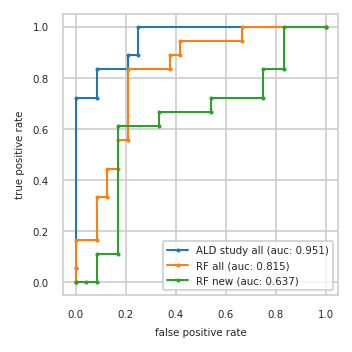

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       RF all       RF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.000 0.056  0.000 0.056  0.042 0.000
2          0.000 0.722  0.000 0.167  0.083 0.000
3          0.083 0.722  0.083 0.167  0.083 0.111
4          0.083 0.833  0.083 0.333  0.167 0.111
5          0.208 0.833  0.125 0.333  0.167 0.611
6          0.208 0.889  0.125 0.444  0.333 0.611
7          0.250 0.889  0.167 0.444  0.333 0.667
8          0.250 1.000  0.167 0.556  0.542 0.667
9          1.000 1.000  0.208 0.556  0.542 0.722
10           NaN   NaN  0.208 0.833  0.750 0.722
11           NaN   NaN  0.375 0.833  0.750 0.833
12           NaN   NaN  0.375 0.889  0.833 0.833
13           NaN   NaN  0.417 0.889  0.833 1.000
14           NaN   NaN  0.417 0.944  1.000 1.000
15           NaN   NaN  0.667 0.944    NaN   NaN
16           NaN   NaN  0.667 1.000    NaN   NaN
17           NaN   NaN  1.000 1.000    NaN   NaN

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,RF all,RF new
rank,,,
0,P10636-2;P10636-6,Q9Y2T3;Q9Y2T3-3,Q14894
1,Q92542;Q92542-2,P04114,E5RK69;E7EMC6;P08133;P08133-2
2,O95428;O95428-5;O95428-6,A6NNI4;G8JLH6;P21926,K7EPJ5;O60291;O60291-2;O60291-3;O60291-4
3,P61981,P10636-2;P10636-6,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
4,C9JF17;P05090,P61981,Q9NUQ9
5,P04075,P14174,P31321
6,P14174,Q14894,H0Y7T8;P49418;P49418-2
7,P00338;P00338-3,P25189;P25189-2,Q96GD0
8,Q6EMK4,P04075,J3KSJ8;Q9UD71;Q9UD71-2


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf


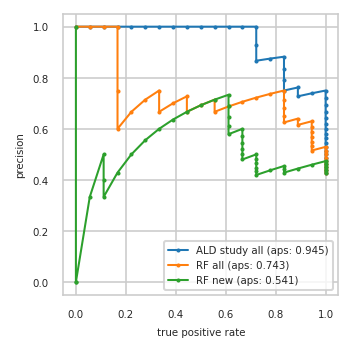

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          RF all          RF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.459 0.944
6          0.500 1.000     0.500 1.000     0.444 0.889
7          0.514 1.000     0.514 1.000     0.429 0.833
8          0.529 1.000     0.529 1.000     0.441 0.833
9          0.545 1.000     0.515 0.944     0.455 0.833
10         0.562 1.000     0.531 0.944     0.438 0.778
11         0.581 1.000     0.548 0.944     0.419 0.722
12         0.600 1.000     0.567 0.944     0.433 0.722
13         0.621 1.000     0.586 0.944     0.448 0.722
14         0.643 1.000     0.607 0.944     0.464 0.722
15         0.667 1.000     0.630 0.944     0.481 0.722
16         0.692 1.000     0.615 0.889     0.500 0.722
17         0.720 1.000     0.640 0.889     0.480 0.667
18         0.750 1.000     0.625 0.833     0.500 0.667
19         0.739 0.944     0.652 0.833     0.522 0.667
20         0.727 0.889     0.682 0.833     0.545 0.667
21         0.762 0.889     0.714 0.833     0.571 0.667
22         0.750 0.833     0.750 0.833     0.600 0.667
23         0.789 0.833     0.737 0.778     0.579 0.611
24         0.833 0.833     0.722 0.722     0.611 0.611
25         0.882 0.833     0.706 0.667     0.647 0.611
26         0.875 0.778     0.688 0.611     0.688 0.611
27         0.867 0.722     0.667 0.556     0.733 0.611
28         0.929 0.722     0.714 0.556     0.714 0.556
29         1.000 0.722     0.692 0.500     0.692 0.500
30         1.000 0.667     0.667 0.444     0.667 0.444
31         1.000 0.611     0.727 0.444     0.636 0.389
32         1.000 0.556     0.700 0.389     0.600 0.333
33         1.000 0.500     0.667 0.333     0.556 0.278
34         1.000 0.444     0.750 0.333     0.500 0.222
35         1.000 0.389     0.714 0.278     0.429 0.167
36         1.000 0.333     0.667 0.222     0.333 0.111
37         1.000 0.278     0.600 0.167     0.400 0.111
38         1.000 0.222     0.750 0.167     0.500 0.111
39         1.000 0.167     1.000 0.167     0.333 0.056
40         1.000 0.111     1.000 0.111     0.000 0.000
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf


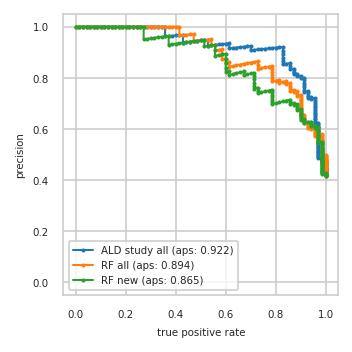

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf


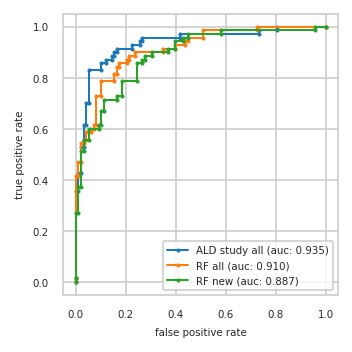

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_RF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF all.pkl'),
 'results_RF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf')}